In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
data = pd.read_csv('Molecular-data.csv')
data[:10]

,Molar volume,Density
0,26.379294,5.254
1,25.847969,5.362
2,26.510484,5.228
3,25.737570,5.385
4,25.402642,5.456
5,24.931968,5.559
6,26.612291,5.208
7,26.694301,5.192
8,26.434639,5.243
9,26.495280,5.231


In [ ]:
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)
train_dataset[:10]

,Molar volume,Density
28,26.407447,5.435
11,25.019625,5.638
10,25.370620,5.560
41,27.711805,5.357
2,26.510484,5.228
27,26.892351,5.337
38,29.811785,4.897
31,29.069755,5.022
22,26.305806,5.456
4,25.402642,5.456


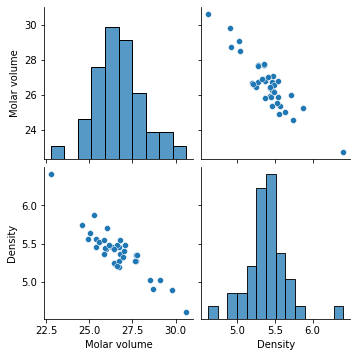

In [ ]:
sns.pairplot(train_dataset[['Molar volume', 'Density']], diag_kind='hist')

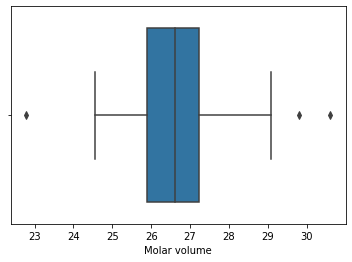

In [ ]:
sns.boxplot(x=train_dataset['Molar volume'])

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Molar volume,40.0,26.670893,1.430829,22.778641,25.89957,26.604407,27.238629,30.605477
Density,40.0,5.392525,0.288503,4.609000,5.27450,5.418500,5.497750,6.409000


In [ ]:
# Collect input feature for training, molar volume value in this case
train_features = train_dataset.copy() #dataframe type
test_features = test_dataset.copy()

# Collect respective label, density value in this case
train_labels = train_features.pop('Density') # series type
test_labels = test_features.pop('Density')

In [ ]:
train_features[:10]

,Molar volume
28,26.407447
11,25.019625
10,25.370620
41,27.711805
2,26.510484
27,26.892351
38,29.811785
31,29.069755
22,26.305806
4,25.402642


In [ ]:
# respective label
train_labels[:10]

28    5.435
11    5.638
10    5.560
41    5.357
2     5.228
27    5.337
38    4.897
31    5.022
22    5.456
4     5.456
Name: Density, dtype: float64

In [ ]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[26.670893]


In [ ]:
raw = np.array(train_features[:10])

with np.printoptions(precision=4, suppress=True):
  print('Before normalize:', raw)
  print()
  print('Normalized:', normalizer(raw).numpy())

Before normalize: [[26.4074]
 [25.0196]
 [25.3706]
 [27.7118]
 [26.5105]
 [26.8924]
 [29.8118]
 [29.0698]
 [26.3058]
 [25.4026]]

Normalized: [[-0.1865]
 [-1.1688]
 [-0.9203]
 [ 0.7368]
 [-0.1135]
 [ 0.1567]
 [ 2.2231]
 [ 1.6979]
 [-0.2584]
 [-0.8977]]


In [ ]:
molar_volume = np.array(train_features['Molar volume'])

molar_volume_normalizer = preprocessing.Normalization(input_shape=[1,])
molar_volume_normalizer.adapt(molar_volume)

In [ ]:
basic_model = tf.keras.Sequential([
    molar_volume_normalizer,
    layers.Dense(units=1)
])

basic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
basic_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
# check the weights and bias
basic_model.get_weights()[-2:]

[array([[1.4880306]], dtype=float32), array([0.], dtype=float32)]

In [ ]:
history = basic_model.fit(
    train_features['Molar volume'], train_labels,
    epochs=100,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 5.3116 - val_loss: 5.6350
Epoch 2/100
1/1 [==============================] - 0s 132ms/step - loss: 5.2069 - val_loss: 5.5538
Epoch 3/100
1/1 [==============================] - 0s 28ms/step - loss: 5.1205 - val_loss: 5.4501
Epoch 4/100
1/1 [==============================] - 0s 28ms/step - loss: 5.0243 - val_loss: 5.3409
Epoch 5/100
1/1 [==============================] - 0s 29ms/step - loss: 4.9244 - val_loss: 5.2289
Epoch 6/100
1/1 [==============================] - 0s 28ms/step - loss: 4.8227 - val_loss: 5.1152
Epoch 7/100
1/1 [==============================] - 0s 26ms/step - loss: 4.7198 - val_loss: 5.0004
Epoch 8/100
1/1 [==============================] - 0s 28ms/step - loss: 4.6182 - val_loss: 4.8888
Epoch 9/100
1/1 [==============================] - 0s 31ms/step - loss: 4.5213 - val_loss: 4.7798
Epoch 10/100
1/1 [==============================] - 0s 28ms/step - loss: 4.4235 - val_loss: 4.6732
Epoch 11/100
1/1 [==

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

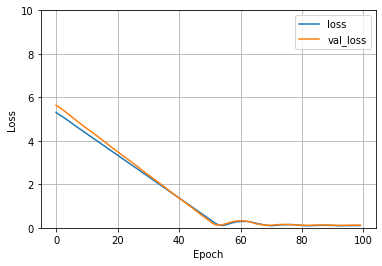

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_loss(history)

In [ ]:
test_results = basic_model.evaluate(
    test_features['Molar volume'],
    test_labels, verbose=1)

1/1 [==============================] - 0s 13ms/step - loss: 0.1358


In [ ]:
test_results

0.1357758492231369

In [ ]:
def plot_density(x, y):
  plt.scatter(train_features['Molar volume'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Molar volume')
  plt.ylabel('Density')
  plt.legend()

In [ ]:
pred_y = basic_model.predict(train_features)

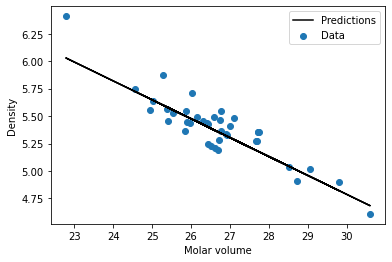

In [ ]:
plot_density(train_features,pred_y)

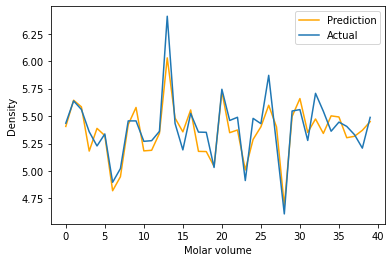

In [ ]:
actual_trend=train_labels.values
plt.plot(pred_y, color='orange', label='Prediction')
plt.plot(actual_trend, label='Actual')
plt.xlabel('Molar volume')
plt.ylabel('Density')
plt.legend()

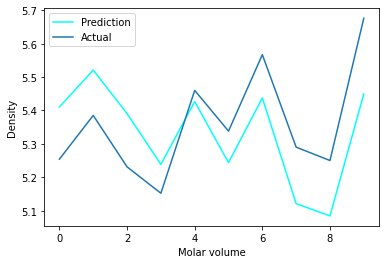

In [ ]:
pred_test = basic_model.predict(test_features)
actual_test_trend=test_labels.values
plt.plot(pred_test, color='cyan', label='Prediction')
plt.plot(actual_test_trend, label='Actual')
plt.xlabel('Molar volume')
plt.ylabel('Density')
plt.legend()

In [ ]:
differences = (1 - sum(abs(pred_test - actual_test_trend.reshape(-1,1)))/len(actual_test_trend)) * 100
pred_accuracy = differences.item()
pred_accuracy

86.42241016387939